# Évaluation des prévisions d'ensemble à travers une analyse statistique sur des données de température et de vent (ARPEGE) 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, gamma

%matplotlib inline

np.set_printoptions(threshold=np.inf)

## VARIABLES

In [ ]:
#############
# Variables #
#############

# Nombre de membres
kT = 34 
kV = 35
kVa = 35
# Nombre de jours testés
NT = 12600
NV = 33090
NVa = 12600
# Variables vent
delta = 7
epsilon = 0.01



## FONCTIONS

### probabilités

In [ ]:
def prob(cond_prev, k, N):
    if k == 1:
        prob = cond_prev.astype(int)
    else:
        prob = np.sum(cond_prev, axis=1)/k
    return prob

### fréquence Np

In [ ]:
def Np(prob):
    # np.unique nous sort la liste de valeurs (vals) qu'on regarde 
    # avec ses fréquences correspondentes (counts) 
    vals, counts = np.unique(prob, return_counts=True)
    return np.vstack([vals, counts]).T

### p'(p)

In [ ]:
def pPrime(cond_obs, prob, Np):
    cond_obs= np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    Np = np.asarray(Np)
    # On prend le vecteur de probas
    pVals = Np[:,0]
    # On créé une matrice booléenne qui indique les jours qui ont une proba p
        # Il s'agit de comparer toutes les probas avec les resultats de TOUS les jours
        # mask[j,i] = True sii prob[j] == pVals[i]
    mask = prob[:, None] == pVals[None,:] 
    # Pour chaque p, on additionne les cond_obs des jours où prob(jour) = p
        # mask et cond_obs agissent comme des indicatrices de p et epsilon 
        # en les mutipliant on obtient la double condition: evenement produit et p prévu
    sums = mask.T @ cond_obs 
    # On divise entre les fréquences Np
    p_prime = sums/Np[:,1]
    return np.column_stack([pVals, p_prime])

### Hit rate (H)

In [ ]:
def H(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    pCats = np.arange(k+1)/k
    N1 = cond_obs.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Hvals = (mask * cond_obs[:, None]).sum(axis=0) / N1
    return Hvals

### False Alarm (F)

In [ ]:
def F(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    indC = 1 - cond_obs
    pCats = np.arange(k+1)/k
    N0 = indC.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Fvals = (mask * indC[:, None]).sum(axis=0) / N0
    return Fvals

### probabilité climatologique

In [ ]:
def pC(cond_obs, N):
    return np.mean(cond_obs)

### score de Brier

In [ ]:
# Fiabilité
def BrierFiab(Np, pPrime, N): 
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (Np[:,0] - pPrime[:,1])**2) / N

# Résolution
def BrierRes(Np, pPrime, N, pc):
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (pPrime[:,1] - pc)**2) / N

# Score de Brier
def Brier(Np, pPrime, N, pc):
    return BrierFiab(Np, pPrime, N) - BrierRes(Np, pPrime, N, pc) + pc * (1-pc)

# Brier Skill Score
def BSS(Np, pPrime, N, pc):
    bf = BrierFiab(Np, pPrime, N)
    br = BrierRes(Np, pPrime, N, pc)
    bi = pc * (1-pc)
    return (br - bf)/bi

## MAIN

In [ ]:
# DONNÉES
#########
dfT = pd.read_csv("donnees_test_temperature.txt", delim_whitespace=True, header=None)
dfV = pd.read_csv("donnees_test_vent.txt", delim_whitespace=True, header=None)
dfVa = pd.read_csv("donnees_test_vent_analyse.txt", delim_whitespace=True, header=None)

# Temperature
obsT = dfT.iloc[:, -1] 
prevT = dfT.iloc[:, 0:kT].to_numpy()

# Vent observation
obsV = dfV.iloc[:, -1] 
prevV = dfV.iloc[:, 0:kV].to_numpy()

# Vent analyse
obsVa = dfVa.iloc[:, -1]
prevVa = dfVa.iloc[:, 0:kVa].to_numpy()

In [ ]:
" En voyant le nombre de fois où nous allons repeter les mêmes  "
" lignes de code, on va faire des fonctions principales pour    "
" le main afin de mieux ranger notre code                       "

def mainExec(obs, prev, k, N, percentile):
    # ÉLÉMENTS DE CALCUL
    ####################
    # Condition à établir
    cond = np.percentile(obs, percentile)
    # Événement théorique
    Etheo = prev > cond
    # Événement observé
    Eobs = obs > cond
    # Vecteur de probabilités par jour
    prob_vecteur = prob(Etheo, k, N)
    # Matrice de fréquences de probabilités
    Np_matrice = Np(prob_vecteur)
    Np_matrice = np.array(Np_matrice)
    # Matrices de fréquences réelles (p'(p))
    pPrime_matrice = pPrime(Eobs, prob_vecteur, Np_matrice)
    # Probabilité climatologique
    pc = pC(Eobs, N)
    # H et F
    hit_rate = H(Eobs, prob_vecteur, k)
    false_alarm = F(Eobs, prob_vecteur, k)

    # SCORES
    ########
    # brierScore = Brier(Np_matrice, pPrime_matrice, N, pc)
    # brierSkill = BSS(Np_matrice, pPrime, N, pc)
    
    return cond, Etheo, Eobs, Np_matrice, pPrime_matrice, pc, hit_rate, false_alarm  

In [ ]:
condT50, EtheoT50, EobsT50, NpT50, pPrimeT50, pcT50, HT50, FT50 = mainExec(obsT, prevT, kT, NT, 50)
condT90, EtheoT90, EobsT90, NpT90, pPrimeT90, pcT90, HT90, FT90 = mainExec(obsT, prevT, kT, NT, 90)

condV50, EtheoV50, EobsV50, NpV50, pPrimeV50, pcV50, HV50, FV50 = mainExec(obsV, prevV, kV, NV, 50)
condV90, EtheoV90, EobsV90, NpV90, pPrimeV90, pcV90, HV90, FV90 = mainExec(obsV, prevV, kV, NV, 90)

condVa50, EtheoVa50, EobsVa50, NpVa50, pPrimeVa50, pcVa50, HVa50, FVa50 = mainExec(obsVa, prevVa, kV, NV, 50)
condVa90, EtheoVa90, EobsVa90, NpVa90, pPrimeVa90, pcVa90, HVa90, FVa90 = mainExec(obsVa, prevVa, kV, NV, 90)

## DIAGRAMMES

In [ ]:
# Diagramme de fiabilité
########################

pc = [pcT50, pcT90, pcV50, pcV90, pcVa50, pcVa90]

dict_fiab = {"Température_50": pPrimeT50, "Température_90": pPrimeT90,
            "Vent_obs_50": pPrimeV50, "Vent_obs_90": pPrimeV90,
            "Vent_analyse_50": pPrimeVa50, "Vent_analyse_90": pPrimeVa90}
# Diagramme d'acuité
####################

dict_acuite = {"Température_50": NpT50, "Température_90": NpT90,
                "Vent_obs_50": NpV50, "Vent_obs_90": NpV90,
                "Vent_analyse_50": NpVa50, "Vent_analyse_90": NpVa50}

# Courbe de ROC
###############

FHT50 = np.vstack((FT50, HT50)).T
FHT90 = np.vstack((FT90, HT90)).T
FHV50 = np.vstack((FV50, HV50)).T
FHV90 = np.vstack((FV90, HV90)).T
FHVa50 = np.vstack((FVa50, HVa50)).T
FHVa90 = np.vstack((FVa90, HVa90)).T

dict_ROC = {"Température_50": FHT50, "Température_90": FHT90,
                "Vent_obs_50": FHV50, "Vent_obs_90": FHV90,
                "Vent_analyse_50": FHVa50, "Vent_analyse_90": FHVa90}

Fiab=True
Acuite=True
ROC=True


In [ ]:
def graphsExec(Fiab, Acuite, ROC, dict_fiab, pc, dict_acuite, dict_ROC, per, nVar):
    
    # Titres Fiabilité
    titre_fiab = "Diagramme de fiabilité: 50 et 90"
    titre_variable_fiab = "pPrime(p)"
    xlabel_fiab = "probabilités (%)"
    ylabel_fiab = "fréquence réelle (%)"
    
    # Titres Acuité
    titre_acuite = "Diagramme d'acuité: 50 et 90"
    titre_variable_acuite= ""
    xlabel_acuite = "probabilités (%)"
    ylabel_acuite = "fréquence (%)"
    
    # Titres ROC 
    titre_ROC = "Courbe ROC: 50 et 90"
    titre_variable_ROC = "H(F)"
    xlabel_ROC = "False alarm"
    ylabel_ROC = "Hit rate"

    
    if Fiab==True:
        PC=True
        SCT=False
        graphic_plt_id(dict_fiab, len(per), nVar, pc, PC, titre_fiab, titre_variable_fiab, xlabel_fiab, ylabel_fiab, SCT)
        
    if Acuite==True:
        graphic_bar(dict_acuite, len(per), nVar, titre_acuite, titre_variable_acuite, xlabel_acuite, ylabel_acuite)
        
    if ROC==True:
        PC=False
        SCT=True
        graphic_plt_id(dict_ROC, len(per), nVar, pc, PC, titre_ROC, titre_variable_ROC, xlabel_ROC, ylabel_ROC, SCT)

In [ ]:
def graphic_plt_id (dictionnaire, nPer, nVar, pc, PC, titre, titre_variable, xlabel, ylabel, SCT):
    # nPer = len(per)
    # nVar = len(dictionnaire.keys()
    DEUX=False
    nFig, axs = plt.subplots(nPer, nVar, figsize=(20,14))
    axs = np.atleast_2d(axs)
    
    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())

    for i, (mat) in enumerate(matrices):
        row = (i) % nPer
        col = int(i/nPer)

        vect0 = mat[:,0]
        vect1 = mat[:,1]
        
        if len(mat[0,:]) > 2:
            vect2 = mat[:,2]
            vect3 = mat[:,3]
            DEUX==True
        # Cela voudrait dire qu'on veut plus d'une courbe dans chaque graphique
        axs[row,col].plot(vect0, vect0, label="id", color='blue')
        if SCT == True:
            axs[row,col].scatter(vect0, vect1, label=titre_variable, color='red')
            if DEUX==True:
                axs[row,col].scatter(vect2, vect3, label="avant", color='black')
        else:
            axs[row,col].plot(vect0, vect1, label=titre_variable, color='red')
            if DEUX==True:
                axs[row,col].plot(vect2, vect3, label="avant", color='black')
        if PC == True:
            axs[row,col].plot(vect1, np.full((len(mat),), pc[i]), label="pC", color='green')
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def graphic_bar (dictionnaire, nPer, nVar, titre, titre_variable, xlabel, ylabel):
    nFig, axs = plt.subplots(nPer, nVar, figsize=(20,14))
    axs = np.atleast_2d(axs)

    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())

    for i, (mat) in enumerate(matrices):
        row = (i) % nPer
        col = int(i/nPer)

        vect1 = mat[:,0]
        vect2 = mat[:,1]

        axs[row,col].bar(vect1, vect2, label=titre_variable)
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()


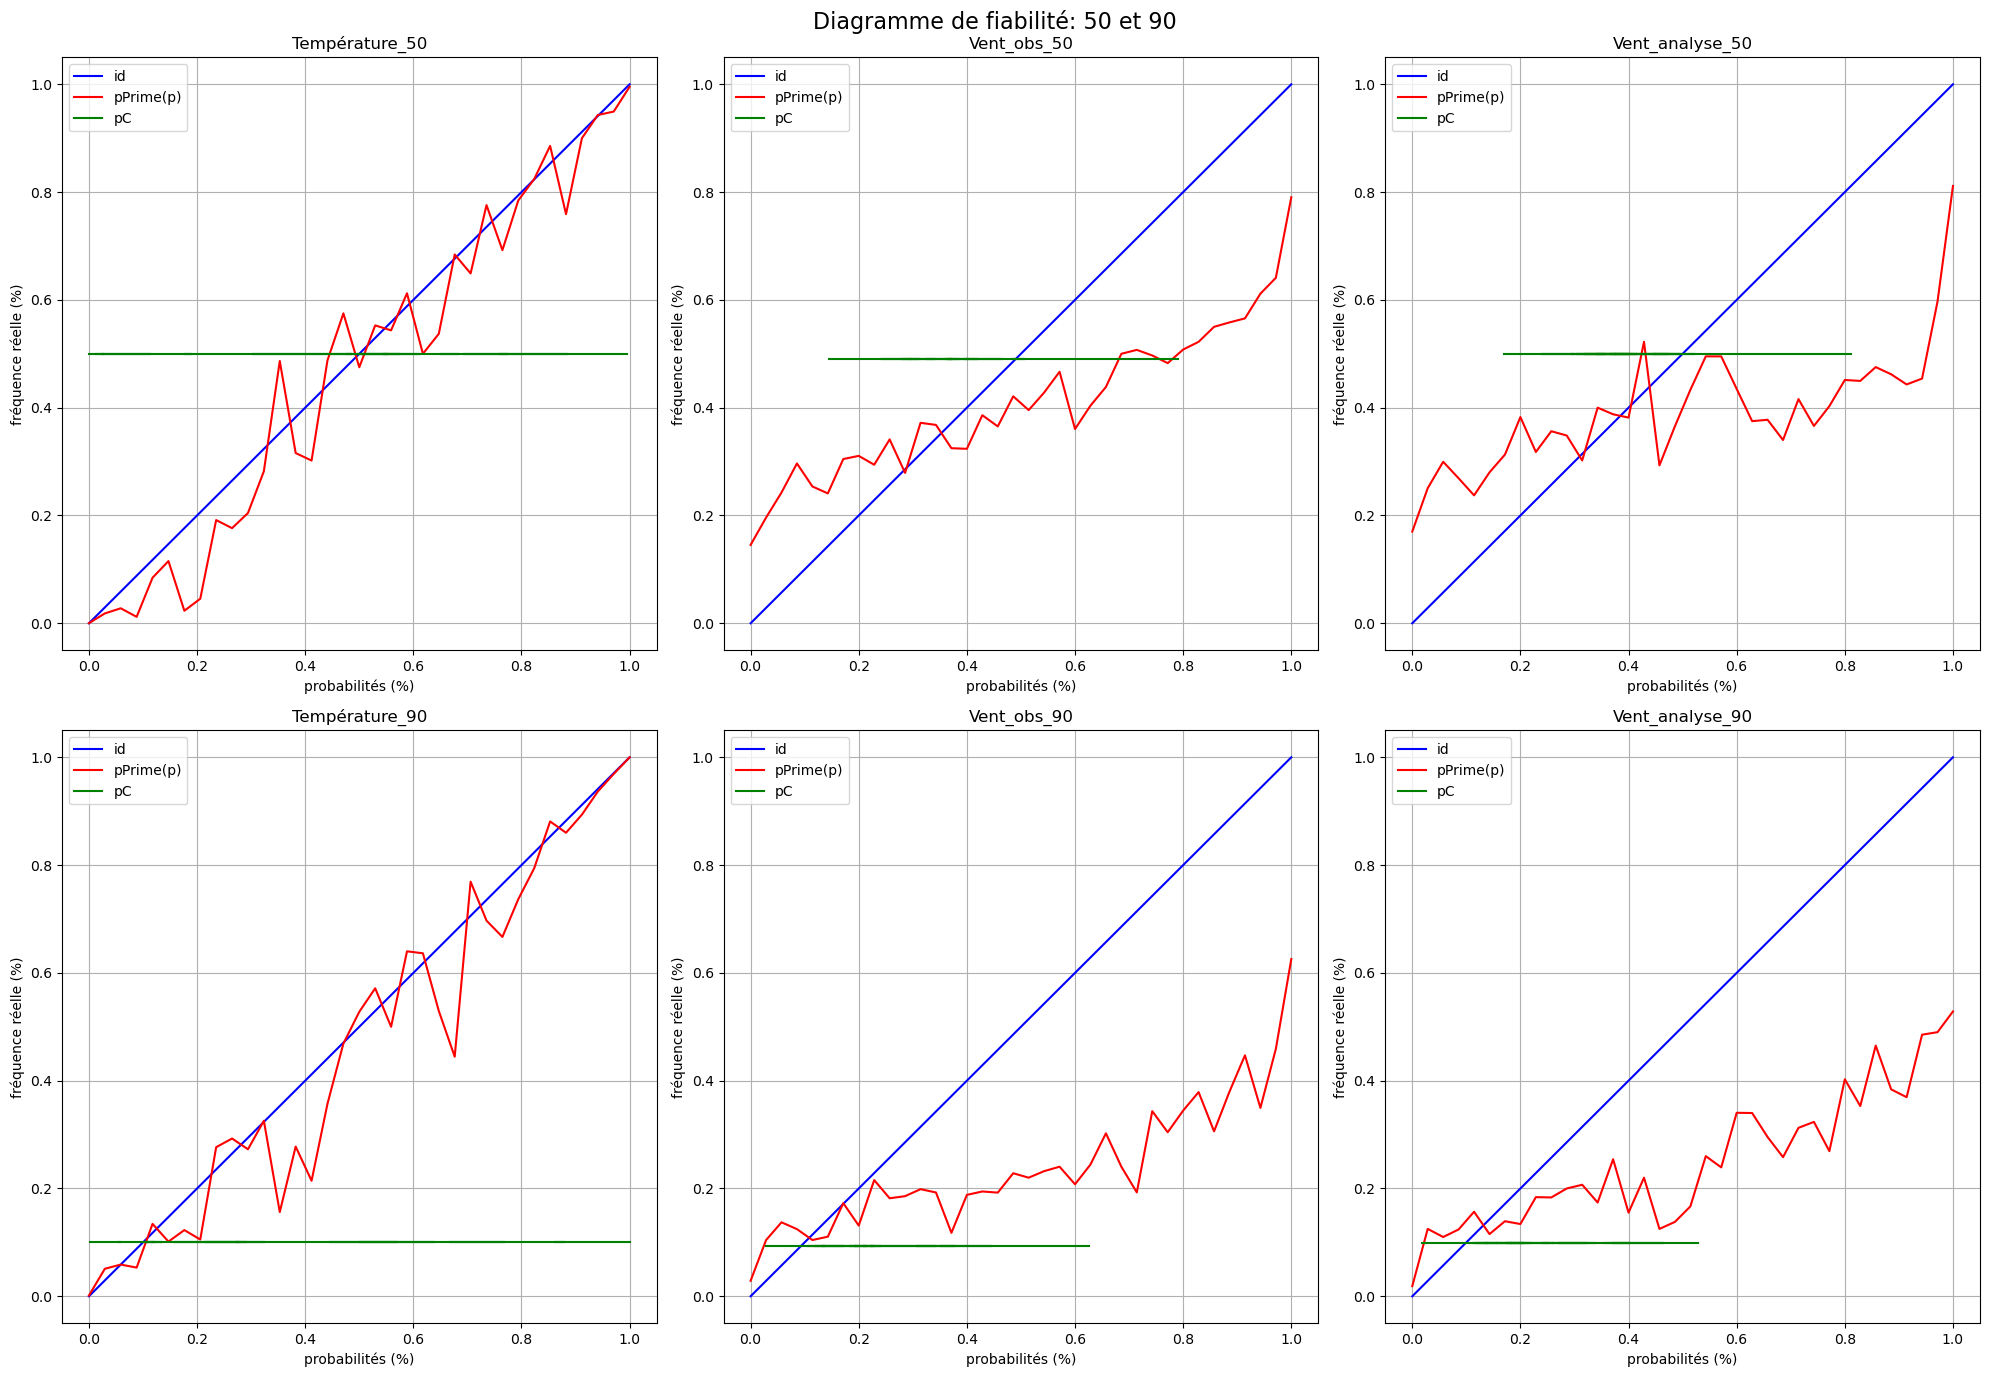

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


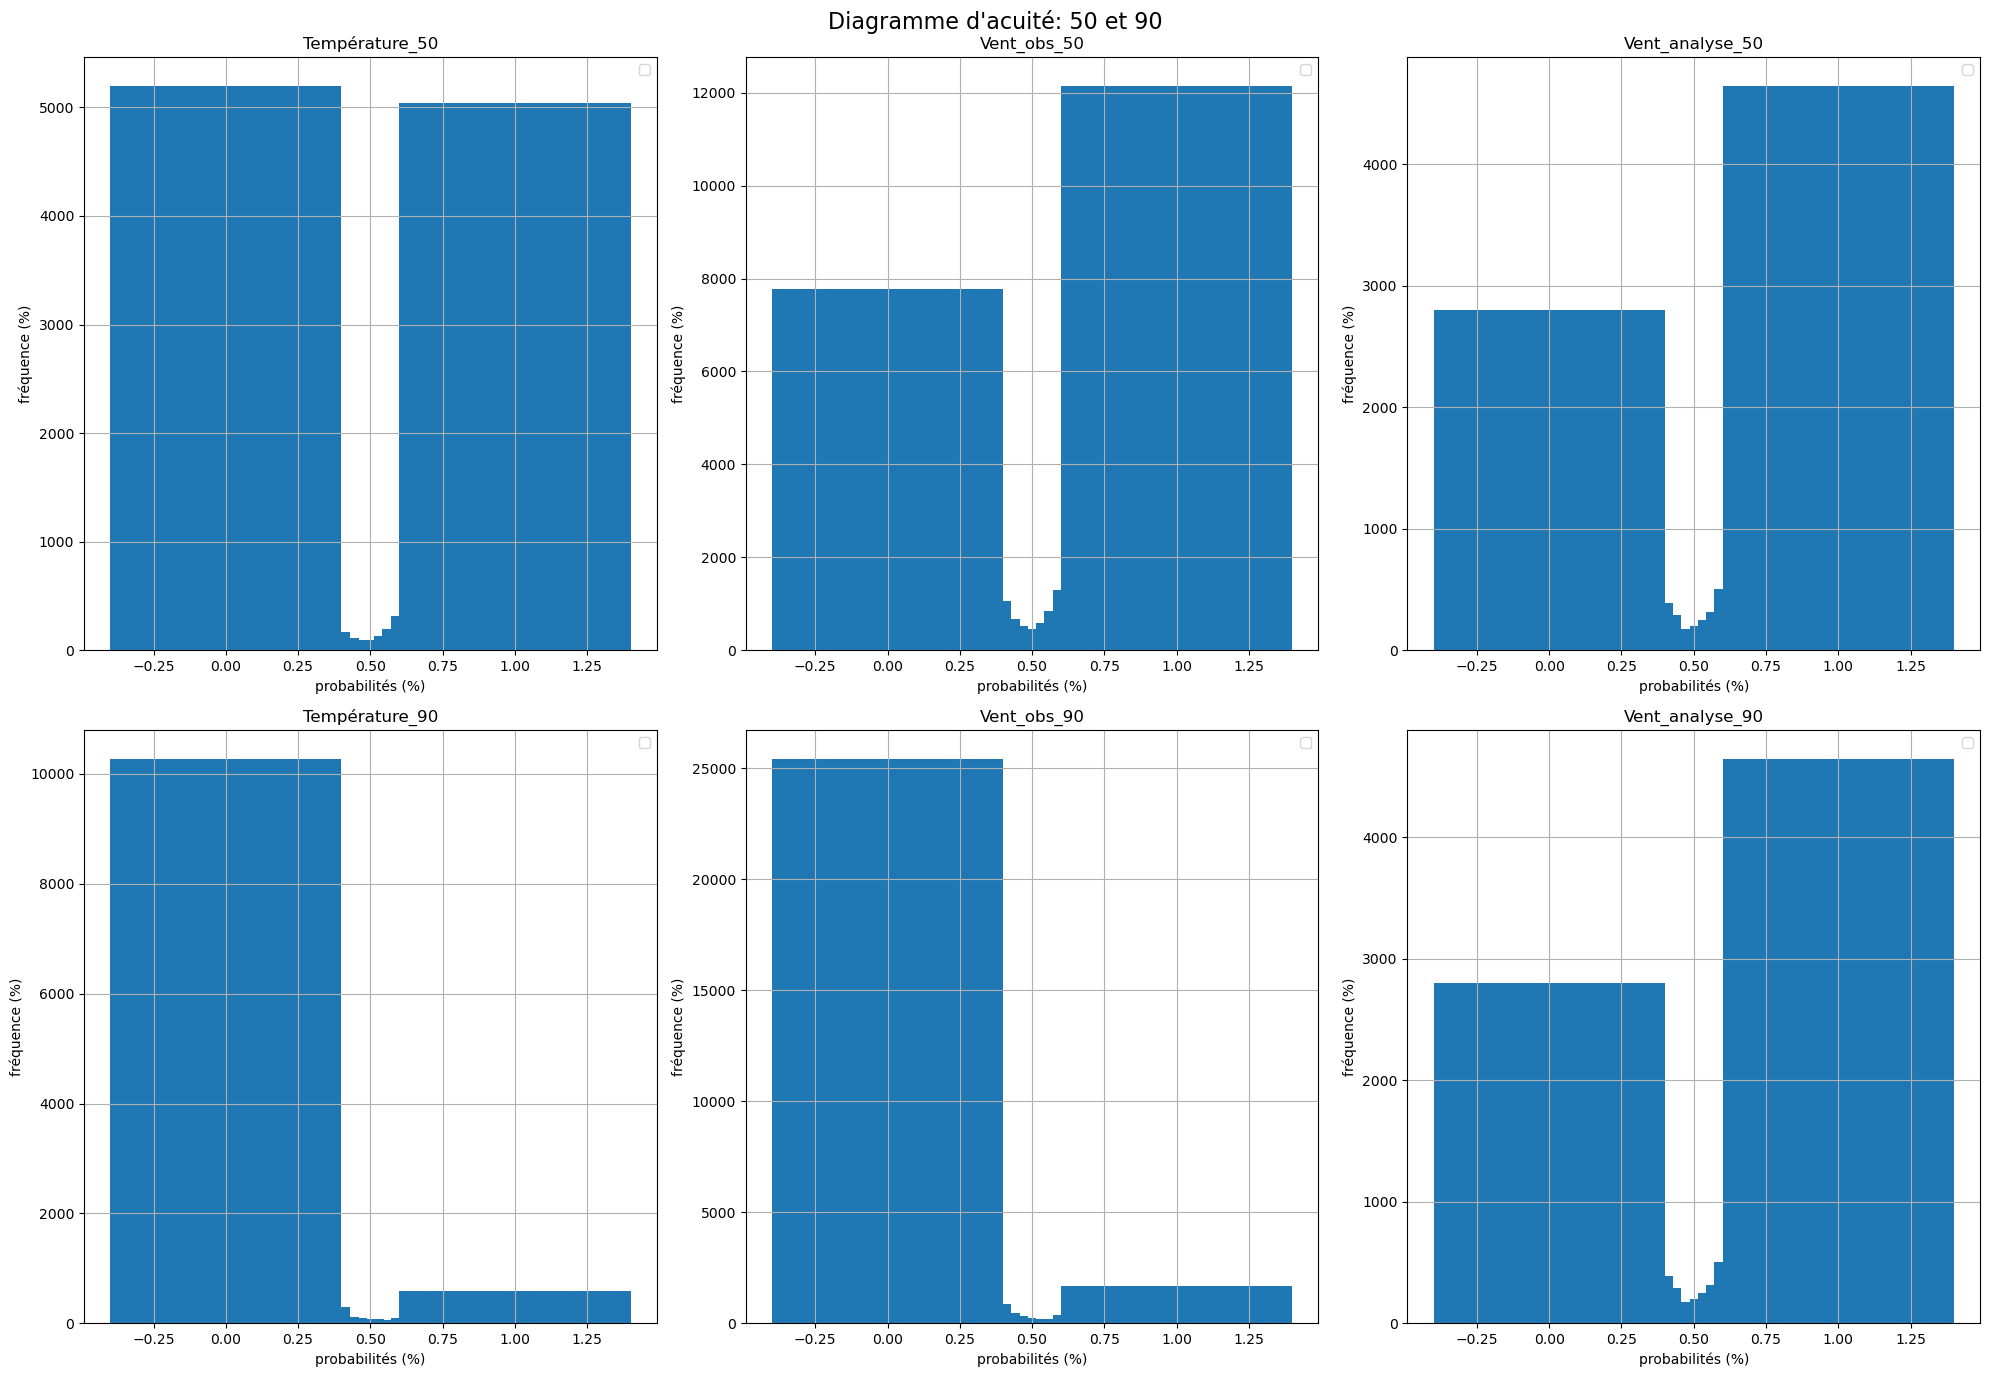

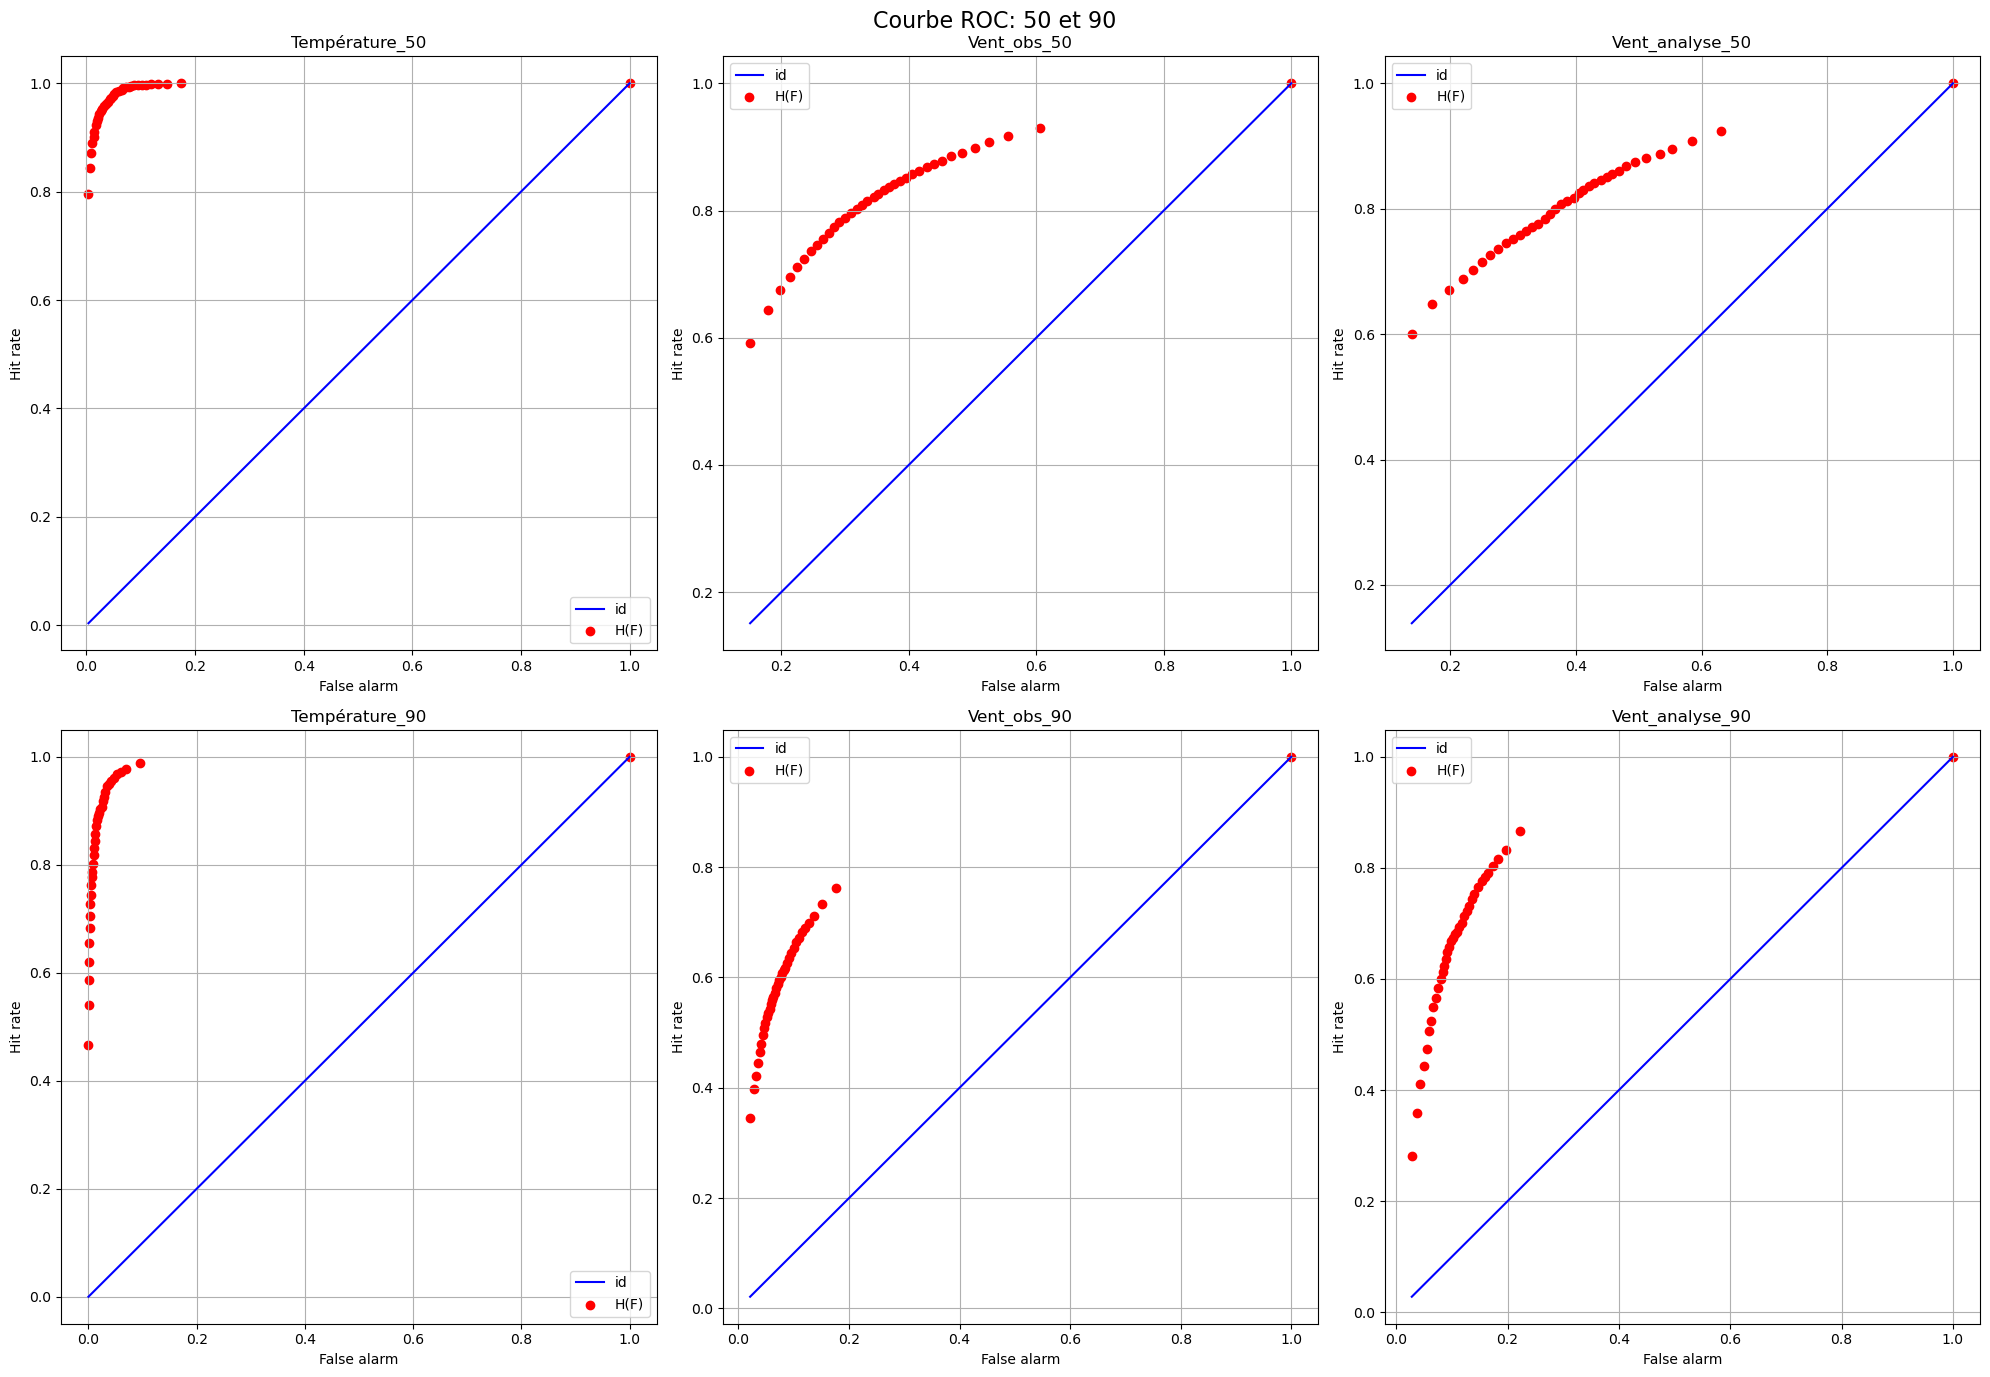

In [ ]:
graphsExec(Fiab, Acuite, ROC, dict_fiab, pc, dict_acuite, dict_ROC, [50, 90], 3)

### diagramme de fiabilité

### diagramme d'acuité

### courbe ROC

### au délà

### Seuil de probabilité idèal

In [ ]:
# Catégorie de probabilité optimale
def pointROC (dictionnaire, k):
    titres = list(dictionnaire.keys())
    matrices = list(dictionnaire.values())
    pCats = np.arange(k+1)/k

    print("Les catégories de probabilité optimale sont:\n")
    for i, mat in enumerate(matrices):
        dist = np.sqrt((mat[:,0])**2 + (mat[:,1] - 1)**2)
        for idx in pCats:
            idx = np.argmin(dist)
        
        print(f"{titres[i]}:\n", pCats[idx])    

    return

In [ ]:
# Catégorie de probabilité optimale.
pointROC(dict_ROC, kT)

Les catégories de probabilité optimale sont:

Température_50:
 0.5882352941176471
Température_90:
 0.17647058823529413
Vent_obs_50:
 0.8235294117647058
Vent_obs_90:
 0.029411764705882353
Vent_analyse_50:
 0.8823529411764706
Vent_analyse_90:
 0.058823529411764705


### Cas detérministe

## ERREURS D'OBSERVATION

### Fonctions pour l'analyse du vent

In [ ]:
def param_vent (maille, y):
    # Ici delta c'est le pas du maillage
    moy_y = y.sum()/(len(y))
    alpha0 = -0.02*maille
    alpha1 = 1 + 0.002*maille
    beta1 = -0.04*maille + 0.17*maille**(0.75)

    moy = alpha0 + alpha1*moy_y
    var = beta1 * np.sqrt(moy_y) + epsilon

    return moy, var

In [ ]:
def conv_vent (y, nVal):
    moy, var = param_vent(delta, y)

    # Paramètres pour la cut-off à 0
    a = (0 - moy) / var
    b = np.inf

    # Distribution de l'erreur 
    dist = truncnorm(a, b, loc=moy, scale=var)
    samples = dist.rvs(size=nVal) # Prend nVal valeurs aléatoires suivant dist
    moy_samples = samples.sum()/nVal
    y += samples - moy_samples

    return y

In [ ]:
avant_1DV_1l = prevV[0,:].ravel()
apres_1DV_1l = conv_vent(prevV[0,:], kV) 
"On fait ça pour controler ligne par ligne aussi (on regarde ce qu'il se passe sur la 1ere)"
avant_1DV = prevV.ravel()
apres_1DV = np.apply_along_axis(conv_vent, 1, prevV, kV).ravel()
avant_1DVa = prevVa.ravel()
apres_1DVa = np.apply_along_axis(conv_vent, 1, prevVa, kVa).ravel()

# Variables de contrôle
mediaV_1l_av = np.mean(avant_1DV_1l)
varV_1l_av = np.var(avant_1DV_1l)

mediaV_av = np.mean(avant_1DV)
varV_av = np.var(avant_1DV)

mediaVa_av = np.mean(avant_1DVa)
varVa_av = np.var(avant_1DVa)

mediaV_1l_ap = np.mean(avant_1DV_1l)
varV_1l_ap = np.var(avant_1DV_1l)

mediaV_ap = np.mean(apres_1DV)
varV_ap = np.var(apres_1DV)

mediaVa_ap = np.mean(apres_1DVa)
varVa_ap = np.var(apres_1DVa)

print("Moyenne 1l vent obs avant/après:", mediaV_1l_av, mediaV_1l_ap)
print("Moyenne vent obs avant/après:", mediaV_av, mediaV_ap)
print("Moyenne vent ana avant/après:", mediaVa_av, mediaVa_ap)

print("Variance 1l vent obs avant/après:", varV_1l_av, varV_1l_ap)
print("Variance vent obs avant/après:", varV_av, varV_ap)
print("Variance vent ana avant/après:", varVa_av, varVa_ap)

Moyenne 1l vent obs avant/après: 14.091999999999999 14.091999999999999
Moyenne vent obs avant/après: 4.297573379959419 4.297573379959417
Moyenne vent ana avant/après: 4.474160770975058 4.474160770975057
Variance 1l vent obs avant/après: 0.9236045714285712 0.9236045714285712
Variance vent obs avant/après: 10.132985369283665 10.996430416510451
Variance vent ana avant/après: 10.635445949662902 11.527100644719958


In [ ]:
def graphic_pdf_cdf (dictionnaire, nPer, nVar, titre, titre_variable, xlabel, ylabel, CDF):

    nFig, axs = plt.subplots(nPer, nVar)
    axs = np.atleast_2d(axs)

    nFig.suptitle(titre, fontsize=16)
    titres = list(dictionnaire.keys())
    series = list(dictionnaire.values())

    for i, ser in enumerate(series):
        if nPer == 1:
            row = 0
            col = i
        else:
            row = (i) % nPer
            col = int(i/nPer)
    
        if CDF==True:
            n = len(ser)
            valeurs_cdf = np.sort(ser)
            cdf = np.arange(1, n+1) / n
            axs[row, col].plot(valeurs_cdf, cdf, label=titre_variable, color='red')

        else:
            axs[row,col].hist(ser,
                bins=50,
                density=True,
                alpha=0.7,
                color='red',
                label=titre_variable
            )
        axs[row,col].set_title(titres[i])
        axs[row,col].set_xlabel(xlabel)
        axs[row,col].set_ylabel(ylabel)
        axs[row,col].legend() 
        axs[row,col].grid(True)

    plt.tight_layout()
    plt.show()


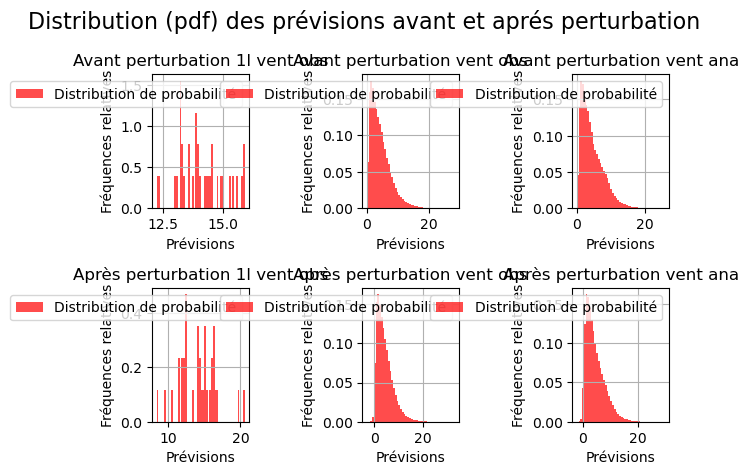

/tmp/ipykernel_61272/1876474431.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


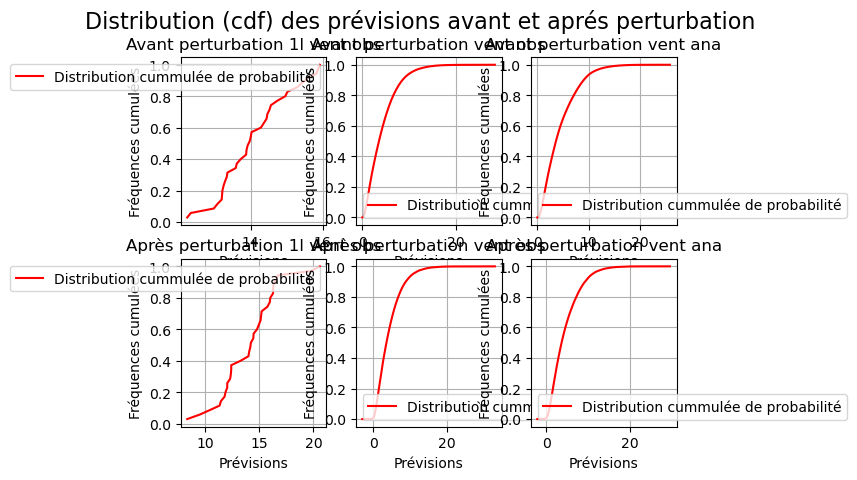

In [ ]:
dict_all = {
    "Avant perturbation 1l vent obs": avant_1DV_1l, 
    "Après perturbation 1l vent obs": apres_1DV_1l,
    "Avant perturbation vent obs": avant_1DV, 
    "Après perturbation vent obs": apres_1DV,
    "Avant perturbation vent ana": avant_1DVa, 
    "Après perturbation vent ana": apres_1DVa
}

titre = "Distribution (pdf) des prévisions avant et aprés perturbation"
titre_variable = "Distribution de probabilité"
xlabel = "Prévisions"
ylabel = "Fréquences relatives"

graphic_pdf_cdf(dict_all, 2, 3, titre, titre_variable, xlabel, ylabel, CDF=False)

titre = "Distribution (cdf) des prévisions avant et aprés perturbation"
titre_variable = "Distribution cummulée de probabilité"
xlabel = "Prévisions"
ylabel = "Fréquences cumulées"

graphic_pdf_cdf(dict_all, 2, 3, titre, titre_variable, xlabel, ylabel, CDF=True)

### Comparaison des mêmes diagrammes

deux is false
vect2= [0.         0.02857143 0.05714286 0.08571429 0.11428571 0.14285714
 0.17142857 0.2        0.22857143 0.25714286 0.28571429 0.31428571
 0.34285714 0.37142857 0.4        0.42857143 0.45714286 0.48571429
 0.51428571 0.54285714 0.57142857 0.6        0.62857143 0.65714286
 0.68571429 0.71428571 0.74285714 0.77142857 0.8        0.82857143
 0.85714286 0.88571429 0.91428571 0.94285714 0.97142857 1.        ]
vect3= [0.14533986 0.19602273 0.24260355 0.29651163 0.25382932 0.24093264
 0.30470914 0.3105802  0.29411765 0.34113712 0.27898551 0.37190083
 0.368      0.32478632 0.3236715  0.38604651 0.36521739 0.42105263
 0.39552239 0.428      0.46666667 0.36042403 0.40377358 0.4384058
 0.5        0.50724638 0.49683544 0.48264984 0.50783699 0.52219321
 0.55       0.55818966 0.56565657 0.61151079 0.64092664 0.79043936]
deux is true
vect2= [0.         0.02857143 0.05714286 0.08571429 0.11428571 0.14285714
 0.17142857 0.2        0.22857143 0.25714286 0.28571429 0.31428571
 0.34285714 0

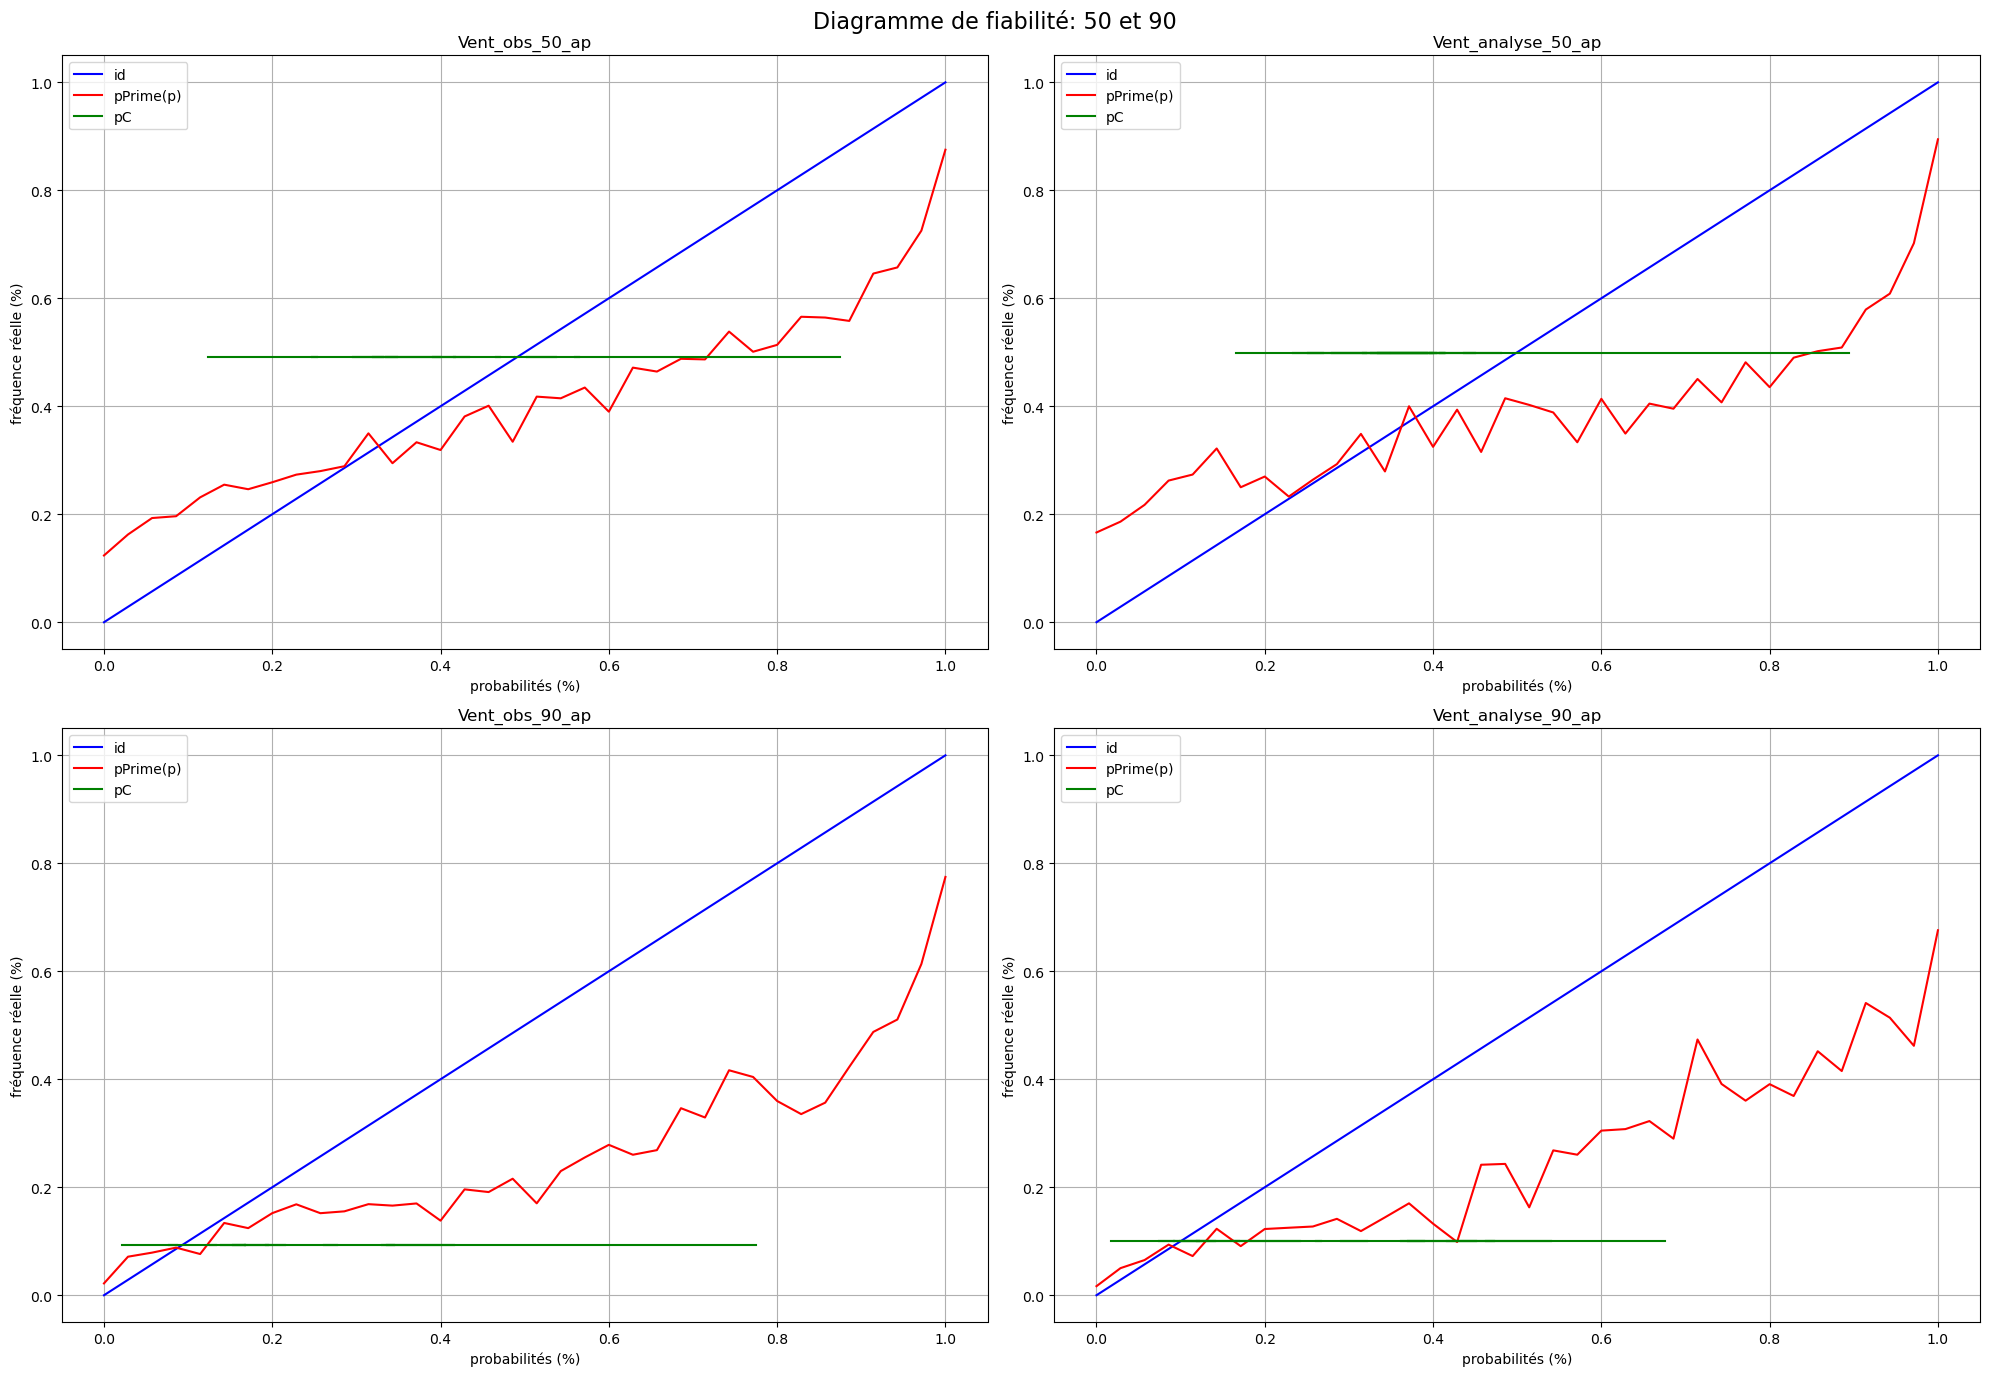

deux is false
vect2= [1.         0.60611095 0.55574014 0.52536339 0.50382676 0.48359537
 0.46621181 0.45132008 0.43933551 0.42794423 0.4162563  0.40444972
 0.39543162 0.38605755 0.37668348 0.36837734 0.36054583 0.35188371
 0.34470484 0.33509344 0.32660931 0.31948977 0.30875111 0.29937704
 0.29018096 0.28294275 0.27487392 0.26544052 0.25571047 0.24639573
 0.23553842 0.22539306 0.2132305  0.19792346 0.17870068 0.15111243]
vect3= [1.         0.93045889 0.91770865 0.90760702 0.89818294 0.89103788
 0.88530952 0.87853403 0.87292886 0.86800123 0.86171851 0.85697567
 0.85143209 0.84576532 0.84108408 0.83695719 0.83184478 0.82667077
 0.82125038 0.81472128 0.80813058 0.80166307 0.79538035 0.78878965
 0.78133662 0.77382199 0.76519864 0.75552818 0.7461041  0.73612565
 0.72380659 0.71093317 0.69497998 0.67428395 0.64287034 0.59174623]
deux is true
vect2= [1.         0.17711735 0.15076298 0.1369361  0.12780702 0.12094356
 0.11477977 0.10951556 0.10421803 0.0998534  0.09595522 0.09215699
 0.08799227 

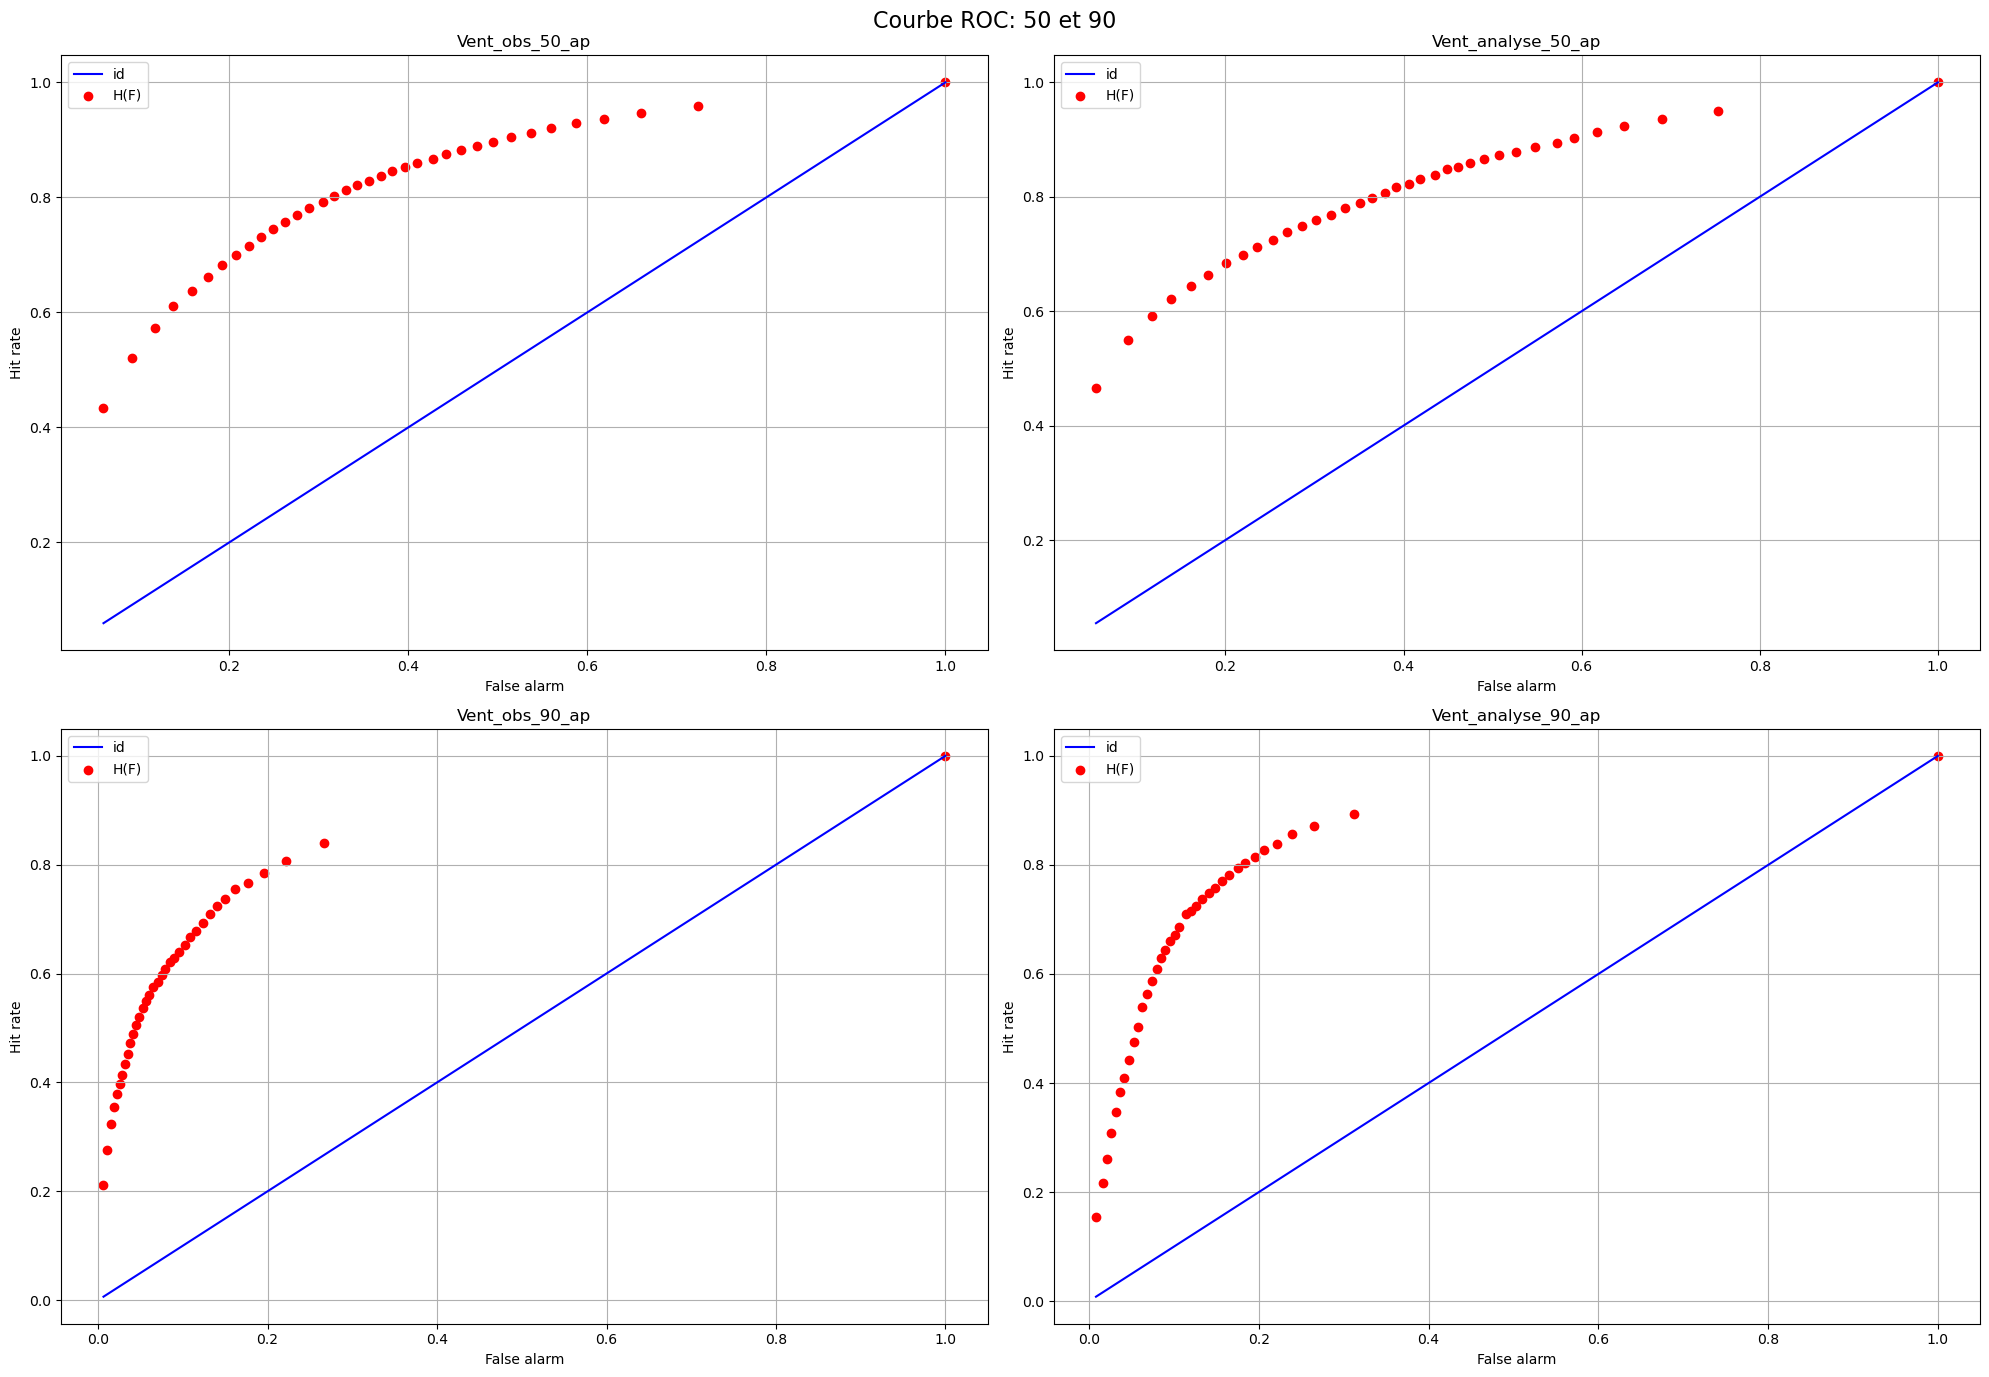

In [ ]:
prevV_ap = apres_1DV.reshape(-1, kV)
prevVa_ap = apres_1DVa.reshape(-1, kVa)

condV50_ap, EtheoV50_ap, EobsV50_ap, NpV50_ap, pPrimeV50_ap, pcV50_ap, HV50_ap, FV50_ap = mainExec(obsV, prevV_ap, kV, NV, 50)
condV90_ap, EtheoV90_ap, EobsV90_ap, NpV90_ap, pPrimeV90_ap, pcV90_ap, HV90_ap, FV90_ap = mainExec(obsV, prevV_ap, kV, NV, 90)

condVa50_ap, EtheoVa50_ap, EobsVa50_ap, NpVa50_ap, pPrimeVa50_ap, pcVa50_ap, HVa50_ap, FVa50_ap = mainExec(obsVa, prevVa_ap, kV, NV, 50)
condVa90_ap, EtheoVa90_ap, EobsVa90_ap, NpVa90_ap, pPrimeVa90_ap, pcVa90_ap, HVa90_ap, FVa90_ap = mainExec(obsVa, prevVa_ap, kV, NV, 90)

# Diagramme de fiabilité
########################
pc_ap = [pcV50_ap, pcV90_ap, pcVa50_ap, pcVa90_ap]

two_pPrimeV50 = np.hstack((pPrimeV50_ap, pPrimeV50))
two_pPrimeV90 = np.hstack((pPrimeV90_ap, pPrimeV90))
two_pPrimeVa50 = np.hstack((pPrimeVa50_ap, pPrimeVa50))
two_pPrimeVa90 = np.hstack((pPrimeVa90_ap, pPrimeVa90))

dict_fiab_ap = {"Vent_obs_50_ap": two_pPrimeV50, "Vent_obs_90_ap": two_pPrimeV90,
                "Vent_analyse_50_ap": two_pPrimeVa50, "Vent_analyse_90_ap": two_pPrimeVa90
                }

# # Diagramme d'acuité
# ####################

dict_acuite_ap = {"Vent_obs_50_ap": NpV50_ap, "Vent_obs_90_ap": NpV90_ap,
            "Vent_analyse_50_ap": NpVa50_ap, "Vent_analyse_90_ap": NpVa50_ap}

# # Courbe de ROC
# ###############

FHV50_ap = np.vstack((FV50_ap, HV50_ap)).T
FHV90_ap = np.vstack((FV90_ap, HV90_ap)).T
FHVa50_ap = np.vstack((FVa50_ap, HVa50_ap)).T
FHVa90_ap = np.vstack((FVa90_ap, HVa90_ap)).T

two_FHV50 = np.hstack((FHV50_ap, FHV50))
two_FHV90 = np.hstack((FHV90_ap, FHV90))
two_FHVa50 = np.hstack((FHVa50_ap, FHVa50))
two_FHVa90 = np.hstack((FHVa90_ap, FHVa90))

dict_ROC_ap = {"Vent_obs_50_ap": two_FHV50, "Vent_obs_90_ap": two_FHV90,
            "Vent_analyse_50_ap": two_FHVa50, "Vent_analyse_90_ap": two_FHVa90}

Acuite=False
graphsExec(Fiab, Acuite, ROC, dict_fiab_ap, pc_ap, dict_acuite_ap, dict_ROC_ap, [50, 90], 2)
